In [2]:
%%bash
# Some set-up specific to google colab.
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
git clone https://github.com/SIDN-IAP/compas-python.git compas-python 2>> install.log
cp compas-python/compas-scores-two-years.csv .

# COMPAS analysis

We recreate the first section of the [Propublica COMPAS analysis](https://github.com/propublica/compas-analysis) in Python.

What follows are the calculations performed for ProPublica's analaysis of the COMPAS Recidivism Risk Scores. It might be helpful to open [the methodology](https://www.propublica.org/article/how-we-analyzed-the-compas-recidivism-algorithm/) in another tab to understand the following.



## Loading the Data

We select fields for severity of charge, number of priors, demographics, age, sex, compas scores, and whether each person was accused of a crime within two years.



In [3]:
import pandas as pd
import datetime

In [4]:
raw_data = pd.read_csv('./compas-scores-two-years.csv')

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

However not all of the rows are useable for the first round of analysis.

There are a number of reasons remove rows because of missing data:

* If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.

* We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.

* In a similar vein, ordinary traffic offenses -- those with a df of 'O' -- will not result in Jail time are removed (only two of them).

* We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.

* We remove rows where there is no score_text ('N/A')

In [6]:
clean_data = raw_data.copy()

In [7]:
# remove instances when the charge date of a defendants COMPAS
# scored crime was not within 30 days from when the person was arrested
clean_data = clean_data[clean_data['days_b_screening_arrest'] <= 30]
clean_data = clean_data[clean_data['days_b_screening_arrest'] >= -30]
print('Num rows: %d' %len(clean_data))

Num rows: 6172


In [8]:
# remove instances when is_recid is = -1
clean_data = clean_data[clean_data['is_recid'] != -1]
print('Num rows: %d' %len(clean_data))

Num rows: 6172


In [9]:
# remove instances when score_text is N/A
clean_data = clean_data[clean_data['score_text'] != 'N/A']
print('Num rows: %d' %len(clean_data))

Num rows: 6172


In [10]:
# remove ordinary traffic offenses
clean_data = clean_data[clean_data['c_charge_degree'] != 'O']
print('Num rows: %d' %len(clean_data))

Num rows: 6172


**Higher COMPAS scores are slightly correlated with a longer length of stay.**



In [11]:
# TODO: find the Pearson correlation between length of stay (jail_out - jail_in) and COMPAS decile

In [12]:
import numpy as np
from datetime import datetime
from scipy.stats import pearsonr

In [13]:
def date_from_str(s):
    return datetime.strptime(s, '%Y-%m-%d %H:%M:%S')

In [14]:
# convert string dates to datetime
length_of_stay = clean_data.apply(
    lambda row: (date_from_str(row['c_jail_out']) - date_from_str(row['c_jail_in'])).days,
    axis=1
)
length_of_stay

0        0
1       10
2        1
5        1
6        6
        ..
7209     1
7210     1
7211     1
7212     1
7213     1
Length: 6172, dtype: int64

In [15]:
# add new "length of stay" column
clean_data['length_of_stay'] = length_of_stay
clean_data.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid,length_of_stay
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1,10
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1,1
5,7,marsha miles,marsha,miles,2013-11-30,Male,1971-08-22,44,25 - 45,Other,...,Low,2013-11-30,2013-11-30,2013-12-01,0,1,853,0,0,1
6,8,edward riddle,edward,riddle,2014-02-19,Male,1974-07-23,41,25 - 45,Caucasian,...,Low,2014-02-19,2014-03-31,2014-04-18,14,5,40,1,1,6


In [16]:
# calculate the correlation
correlation, p_value = pearsonr(clean_data['length_of_stay'], clean_data['decile_score'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.20747808478032673
P-value: 5.4395854629468425e-61


In [17]:
'''
A Pearson correlation coefficient of 0.2 
indicates a weak positive linear relationship between two variables, 
meaning there's a slight tendency for them to increase or decrease together, 
but the relationship isn't strong. 

A p-value this small (essentially zero) 
means the probability that this correlation occurred 
by random chance is virtually non-existent

'''

"\nA Pearson correlation coefficient of 0.2 \nindicates a weak positive linear relationship between two variables, \nmeaning there's a slight tendency for them to increase or decrease together, \nbut the relationship isn't strong. \n\nA p-value this small (essentially zero) \nmeans the probability that this correlation occurred \nby random chance is virtually non-existent\n\n"

**After filtering we have the following demographic breakdown:**

In [19]:
# TODO: find counts for each age group
age_counts = clean_data['age_cat'].value_counts()
age_counts

age_cat
25 - 45            3532
Less than 25       1347
Greater than 45    1293
Name: count, dtype: int64

In [20]:
# TODO: find counts and percentages for each race group
race_counts = clean_data['race'].value_counts()
race_counts

race
African-American    3175
Caucasian           2103
Hispanic             509
Other                343
Asian                 31
Native American       11
Name: count, dtype: int64

In [27]:
rcs = race_counts.sum()
for category, count in race_counts.items():
    print(f'{category}: {(count/rcs) * 100:.2f}%')

African-American: 51.44%
Caucasian: 34.07%
Hispanic: 8.25%
Other: 5.56%
Asian: 0.50%
Native American: 0.18%


In [24]:
# TODO: find counts of each score_text group
score_counts = clean_data['score_text'].value_counts()
score_counts

score_text
Low       3421
Medium    1607
High      1144
Name: count, dtype: int64

In [26]:
# TODO: find counts and percentages for each gender group
sex_counts = clean_data['sex'].value_counts()
sex_counts

sex
Male      4997
Female    1175
Name: count, dtype: int64

In [28]:
scs = race_counts.sum()
for category, count in sex_counts.items():
    print(f'{category}: {(count/rcs) * 100:.2f}%')

Male: 80.96%
Female: 19.04%


In [29]:
# TODO: create interaction table of counts between race/sex interactions
interaction_table = pd.crosstab(clean_data['race'], clean_data['sex'])
interaction_table

sex,Female,Male
race,,
African-American,549,2626
Asian,2,29
Caucasian,482,1621
Hispanic,82,427
Native American,2,9
Other,58,285


In [30]:
# TODO: How many defendants had two-year recidivism in last two years? What percentage of all defendants?
two_year_recid = clean_data[clean_data['two_year_recid'] == 1]
nb_recid = len(two_year_recid)
pc_recid = (len(two_year_recid) / len(clean_data)) * 100

print(f'{nb_recid} had two-year recidivisms, which is {pc_recid}% of all defendants')

2809 had two-year recidivisms, which is 45.51198963058976% of all defendants


Judges are often presented with two sets of scores from the Compas system -- one that classifies people into High, Medium and Low risk, and a corresponding decile score. There is a clear downward trend in the decile scores as those scores increase for white defendants.



In [41]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns

In [37]:
# TODO: plot decile scores by count for African-America defendants
black = clean_data[clean_data['race'] == 'African-American']
print(f'{len(black)} defendants are African-American')

3175 defendants are African-American


In [40]:
black_score_counts = black['decile_score'].value_counts()
black_score_counts

decile_score
1     365
2     346
7     343
4     337
5     323
6     318
9     317
8     301
3     298
10    227
Name: count, dtype: int64

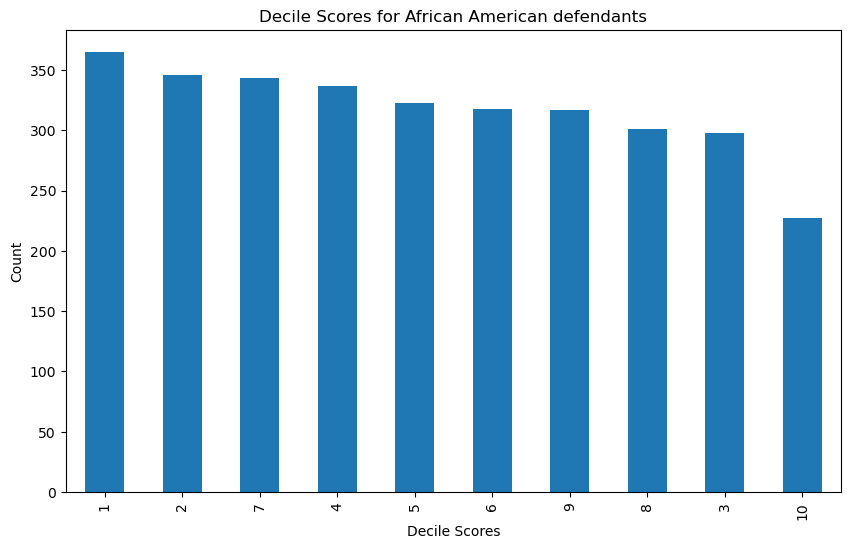

In [42]:
black_score_counts.plot(kind='bar', figsize=(10,6))
plt.title('Decile Scores for African American defendants')
plt.xlabel('Decile Scores')
plt.ylabel('Count')
plt.show()

In [43]:
# TODO: plot decile scores by count for Caucasian defendants
white = clean_data[clean_data['race'] == 'Caucasian']
print(f'{len(white)} defendants are Caucasian')

2103 defendants are Caucasian


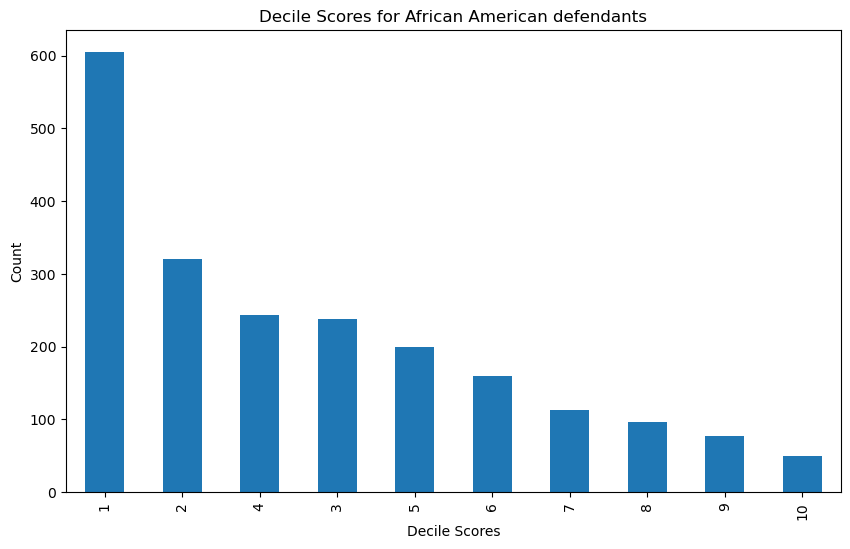

In [44]:
white_score_counts = white['decile_score'].value_counts()

white_score_counts.plot(kind='bar', figsize=(10,6))
plt.title('Decile Scores for African American defendants')
plt.xlabel('Decile Scores')
plt.ylabel('Count')
plt.show()

In [47]:
# TODO: Create a pivot table between decile_score and race
score_and_race = pd.crosstab(clean_data['decile_score'], clean_data['race'])
score_and_race

race,African-American,Asian,Caucasian,Hispanic,Native American,Other
decile_score,,,,,,
1,365,15,605,159,0,142
2,346,4,321,89,2,60
3,298,5,238,73,1,32
4,337,0,243,47,0,39
5,323,1,200,39,0,19
6,318,2,160,27,2,20
7,343,1,113,28,2,9
8,301,2,96,14,0,7
9,317,0,77,17,2,7


## Racial Bias in Compas

After filtering out bad rows, our first question is whether there is a significant difference in Compas scores between races. To do so we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.


In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
lr = LogisticRegression(solver='lbfgs')

In [67]:
# TODO: create columns for all options for charge_degree, age, race, sex, and score_text

# one hot encoding
df_charge = pd.get_dummies(clean_data['c_charge_degree'], prefix='charge')
df_age    = pd.get_dummies(clean_data['age_cat'], prefix='age')
df_race   = pd.get_dummies(clean_data['race'], prefix='race')
df_sex    = pd.get_dummies(clean_data['sex'], prefix='sex')
df_score  = pd.get_dummies(clean_data['score_text'] != 'Low', prefix='score', drop_first=True)

In [55]:
df_sex.head()

,sex_Female,sex_Male
0,False,True
1,False,True
2,False,True
5,False,True
6,False,True


In [68]:
df_score.head()

,score_True
0,False
1,False
2,False
5,False
6,True


In [69]:
x_train = pd.concat([df_charge, df_age, df_race, df_sex,
                clean_data['priors_count'],clean_data['two_year_recid']],axis=1)
y_train   = df_score.values.ravel()

In [73]:
x_train.head()

,charge_F,charge_M,age_25 - 45,age_Greater than 45,age_Less than 25,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,sex_Female,sex_Male,priors_count,two_year_recid
0,True,False,False,True,False,False,False,False,False,False,True,False,True,0,0
1,True,False,True,False,False,True,False,False,False,False,False,False,True,0,1
2,True,False,False,False,True,True,False,False,False,False,False,False,True,4,1
5,False,True,True,False,False,False,False,False,False,False,True,False,True,0,0
6,True,False,True,False,False,False,False,True,False,False,False,False,True,14,1


In [72]:
y_train

array([False, False, False, ..., False, False, False])

In [74]:
# TODO: Run these input features to predict whether score_text is Low or Med/High using a Logistic Regression
lr.fit(x_train, y_train)

LogisticRegression()

In [91]:
example = x_train.iloc[2].values.reshape(1, -1)
lr.predict(example)

C:\Users\ogiev\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


array([ True])

In [92]:
# TODO: What is the correlation coefficient for African_American?

correlation, p_value = pearsonr(df_race['race_African-American'], clean_data['decile_score'])

print(f"Pearson correlation coefficient: {correlation}")
print(f"P-value: {p_value}")

Pearson correlation coefficient: 0.3111648670217925
P-value: 1.1791947051970293e-138


In [88]:
#  What is the odds ratio?
coeff = lr.coef_[0][5]
odds = np.exp(coeff)
odds

1.630989442368501